In [1]:
# ─────────────────────────────────────────────────────────────
#  Cell 1 ▸ Imports & Setup
# ─────────────────────────────────────────────────────────────
import os

import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("✔ Libraries imported successfully!")

✔ Libraries imported successfully!


In [2]:
# ─────────────────────────────────────────────────────────────
#  Cell 2 ▸ Load the trained Random Forest model
# ─────────────────────────────────────────────────────────────
from pathlib import Path

# Get the absolute path to the models directory
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    models_dir = notebook_dir.parent / "models"
else:
    models_dir = notebook_dir / "models"

model_path = models_dir / "RandomForest_regressor.joblib"

if not model_path.exists():
    raise FileNotFoundError(
        f"Model not found at {model_path}. Please run ml-pipeline.ipynb first."
    )

# Load the trained model
rf_model = joblib.load(model_path)

# The model is wrapped in a Pipeline with StandardScaler and MultiOutputRegressor
# We need to extract the actual Random Forest estimators
print(f"Model loaded from: {model_path}")
print(f"Model type: {type(rf_model)}")
print(f"Pipeline steps: {rf_model.steps}")

Model loaded from: d:\GitHub Repos\spray-vision\models\RandomForest_regressor.joblib
Model type: <class 'sklearn.pipeline.Pipeline'>
Pipeline steps: [('scaler', StandardScaler()), ('reg', MultiOutputRegressor(estimator=RandomForestRegressor(max_features='sqrt',
                                                     n_estimators=200,
                                                     random_state=42)))]


In [3]:
# ─────────────────────────────────────────────────────────────
#  Cell 3 ▸ Extract Random Forest estimators from MultiOutputRegressor
# ─────────────────────────────────────────────────────────────
# The pipeline structure is: Pipeline -> StandardScaler -> MultiOutputRegressor -> RandomForestRegressor (multiple)
multi_output_regressor = rf_model.named_steps["reg"]

# Get the individual estimators for each target
# MultiOutputRegressor creates one estimator per target
estimators = multi_output_regressor.estimators_

# Define feature names and target names (same as in ml-pipeline)
feature_names = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
target_names = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]

# Find the index for angle_mie (should be index 0 based on TARGETS order)
angle_mie_index = target_names.index("angle_mie")

# Get the Random Forest estimator for angle_mie prediction
rf_angle_mie = estimators[angle_mie_index]

print(f"Number of estimators (one per target): {len(estimators)}")
print(f"Target names: {target_names}")
print(f"Angle (Mie) is at index: {angle_mie_index}")
print(f"Random Forest for Angle (Mie): {type(rf_angle_mie)}")


Number of estimators (one per target): 4
Target names: ['angle_mie', 'length_mie', 'angle_shadow', 'length_shadow']
Angle (Mie) is at index: 0
Random Forest for Angle (Mie): <class 'sklearn.ensemble._forest.RandomForestRegressor'>


In [4]:
# ─────────────────────────────────────────────────────────────
#  Cell 4 ▸ Extract Feature Importances for Angle (Mie)
# ─────────────────────────────────────────────────────────────
# Get feature importances from the Random Forest model
feature_importances = rf_angle_mie.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values("Importance", ascending=False)

print("\nFeature Importance Scores for Predicting Angle (Mie):")
print("=" * 60)
display(importance_df.style.format({"Importance": "{:.4f}"}))

# Calculate percentage contribution
importance_df["Percentage"] = (
    importance_df["Importance"] / importance_df["Importance"].sum()
) * 100
print(f"\nTotal importance sum: {importance_df['Importance'].sum():.4f}")



Feature Importance Scores for Predicting Angle (Mie):


,Feature,Importance
2,cham_temp,0.4440
0,time,0.1389
4,density,0.1271
3,injection_pres,0.1154
5,viscosity,0.1131
1,chamb_pressure,0.0616



Total importance sum: 1.0000


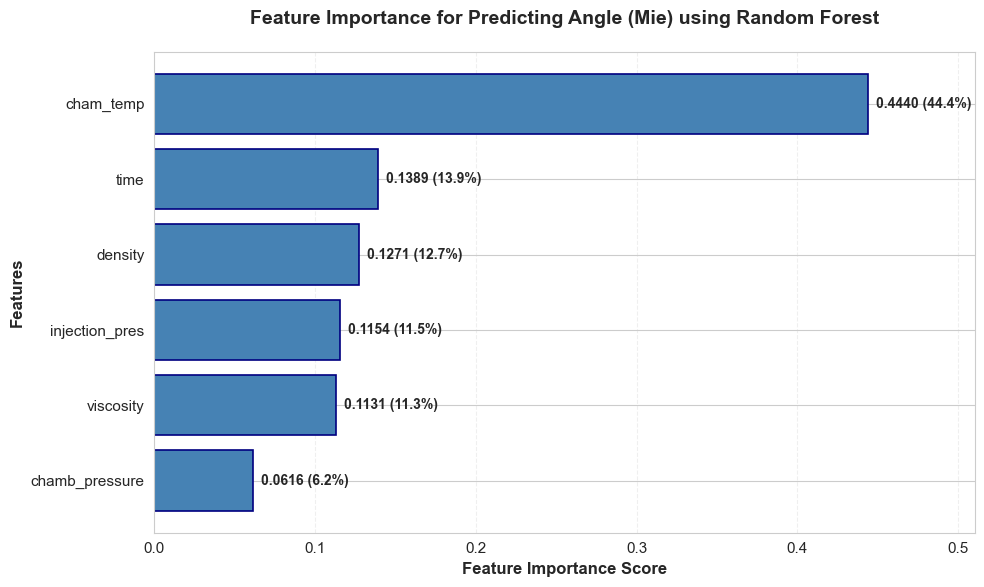

✔ Feature importance plot generated successfully!


In [5]:
# ─────────────────────────────────────────────────────────────
#  Cell 5 ▸ Create Feature Importance Bar Plot
# ─────────────────────────────────────────────────────────────
# Create a professional-looking bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars
bars = ax.barh(
    importance_df["Feature"],
    importance_df["Importance"],
    color="steelblue",
    edgecolor="navy",
    linewidth=1.2,
)

# Add value labels on bars
for i, (importance, percentage) in enumerate(
    zip(importance_df["Importance"], importance_df["Percentage"])
):
    ax.text(
        importance + 0.005,
        i,
        f"{importance:.4f} ({percentage:.1f}%)",
        va="center",
        fontsize=10,
        fontweight="bold",
    )

# Customize the plot
ax.set_xlabel("Feature Importance Score", fontsize=12, fontweight="bold")
ax.set_ylabel("Features", fontsize=12, fontweight="bold")
ax.set_title(
    "Feature Importance for Predicting Angle (Mie) using Random Forest",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.grid(axis="x", alpha=0.3, linestyle="--")
ax.set_xlim(0, max(importance_df["Importance"]) * 1.15)

# Invert y-axis to show highest importance at the top
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("✔ Feature importance plot generated successfully!")


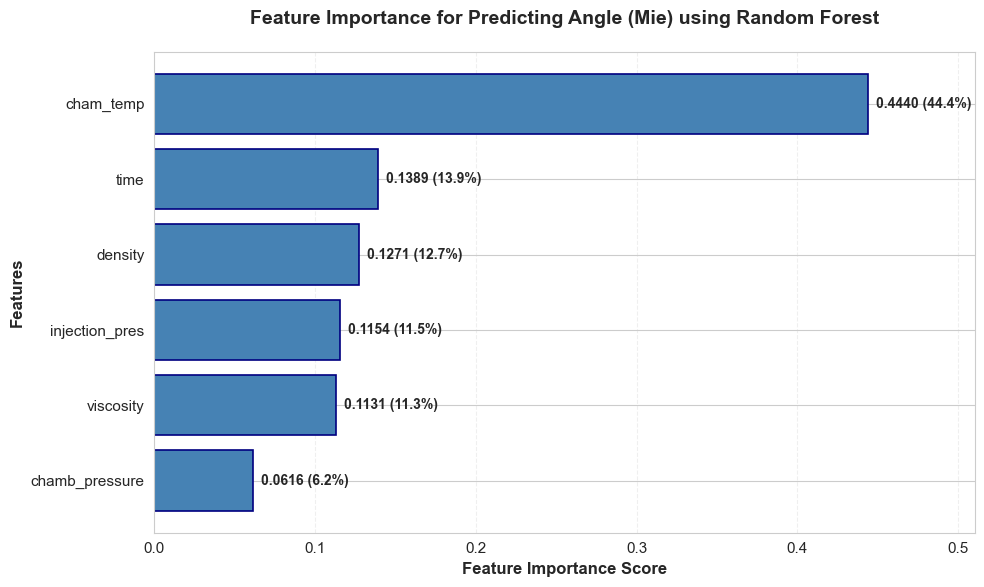

In [6]:
# ─────────────────────────────────────────────────────────────
#  Cell 6 ▸ Save the plot (Optional)
# ─────────────────────────────────────────────────────────────
# Save to the plots or reports/figures directory
output_dir = "../plots"
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "feature_importance_angle_mie_rf.png")

# Recreate the plot for saving
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(
    importance_df["Feature"],
    importance_df["Importance"],
    color="steelblue",
    edgecolor="navy",
    linewidth=1.2,
)

for i, (importance, percentage) in enumerate(
    zip(importance_df["Importance"], importance_df["Percentage"])
):
    ax.text(
        importance + 0.005,
        i,
        f"{importance:.4f} ({percentage:.1f}%)",
        va="center",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel("Feature Importance Score", fontsize=12, fontweight="bold")
ax.set_ylabel("Features", fontsize=12, fontweight="bold")
ax.set_title(
    "Feature Importance for Predicting Angle (Mie) using Random Forest",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.grid(axis="x", alpha=0.3, linestyle="--")
ax.set_xlim(0, max(importance_df["Importance"]) * 1.15)
ax.invert_yaxis()

plt.tight_layout()
# plt.savefig(output_path, dpi=300, bbox_inches="tight")
plt.show()

# print(f"✔ Plot saved to: {output_path}")
